In [1]:
import sys
sys.dont_write_bytecode = True

import torch 
import numpy as np 
from plyfile import PlyData
from projection.projections import camera_to_image, world_to_camera, filter_pixel_points
from projection.utils import get_cameras, get_extrinsic_matrix, get_intrinsic_matrix 
from projection.utils import save_ply

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [6]:
# Read the point cloud
gaussian_file = './projection/point_cloud/iteration_30000/point_cloud.ply' 

In [7]:
pcd = PlyData.read(gaussian_file)['vertex']
pcd_array = np.array([pcd['x'], pcd['y'], pcd['z']], dtype=np.double).T
opacities = pcd['opacity']

In [8]:
pcd_array = torch.from_numpy(pcd_array)
opacities = torch.from_numpy(opacities)
print(pcd_array.shape)

torch.Size([2541226, 3])


In [9]:
# save_ply(pcd_array) 

### Converting World Coordinates to Pixel Coordinates

In [10]:
# Get Cameras 

cameras = get_cameras('./projection/cameras.json')  
i = 15
print('Image Name: ', cameras[i]['img_name'])

WIDTH = cameras[i]['width'] 
HEIGHT = cameras[i]['height']

# Get Extrinsic & intrinsic Matrices for first camera 
extrinsic = get_extrinsic_matrix(cameras[i])  
intrinsic = get_intrinsic_matrix(cameras[i]) 

Image Name:  000121


In [11]:
# Convert to Camera Coordinates 
camera_coords = world_to_camera(pcd_array, extrinsic) 
print(camera_coords) 

tensor([[ -1.3128,   0.8392,  -0.6652,  ..., -26.3548,  24.8861,   3.1334],
        [  0.4786,  -0.9966,  -1.3347,  ...,  -2.5285,  -6.8881, -13.1983],
        [  5.4150,   5.3544,   5.6117,  ..., -10.7645,   4.8875,  38.4651]],
       dtype=torch.float64)


In [12]:
# Convert Camera Coordinates to Pixel Coordinates 
pixel_coords, points_depths, indices = camera_to_image(camera_coords, intrinsic) 
print(pixel_coords.shape) 

torch.Size([2, 1834483])


In [13]:
points_depths

tensor([ 5.4150,  5.3544,  5.6117,  ..., 11.2614,  4.8875, 38.4651],
       dtype=torch.float64)

In [14]:
# Filter points outside the image width and height  

filt_points, filt_depths, filt_indices = filter_pixel_points(
    pixel_coords, points_depths, indices,  WIDTH, HEIGHT) 

In [15]:
print(filt_points) 
print(filt_indices)

tensor([[ 696, 1160,  840,  ..., 1334,  680, 1073],
        [ 647,  330,  270,  ...,  233,  264,  148]], dtype=torch.int32)
tensor([      0,       1,       2,  ..., 2541220, 2541221, 2541225])


In [16]:
img = torch.zeros((HEIGHT, WIDTH))  

x = filt_points[0, :].squeeze() 
y = filt_points[1, :].squeeze()   

img[y, x] = torch.tensor(filt_depths, dtype=torch.float)
print(img)

tensor([[19.4515,  0.0000, 19.4861,  ..., 17.0342, 15.4486, 17.0053],
        [19.4471, 21.0554,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000, 20.4743, 20.4880,  ...,  0.0000,  0.0000, 21.5109],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]])


C:\Users\HP\AppData\Local\Temp\ipykernel_49896\279725728.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img[y, x] = torch.tensor(filt_depths, dtype=torch.float)


In [17]:
from PIL import Image 

im = Image.fromarray((img.numpy()*255).astype(np.uint8), 'L')

name = 'output.png'
im.save(name) 

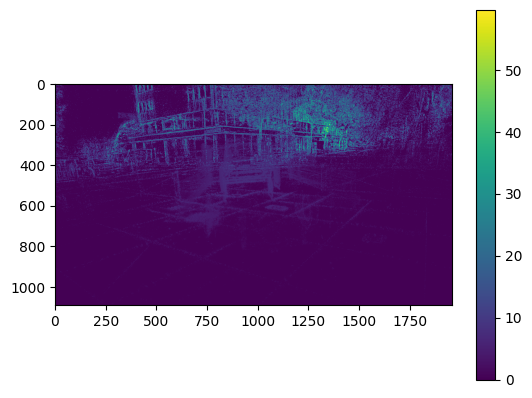

In [18]:
# Visualize grayscale projected view 

import matplotlib.pyplot as plt 

fig, ax = plt.subplots()
cax = ax.imshow(img)
fig.colorbar(cax)

plt.show()

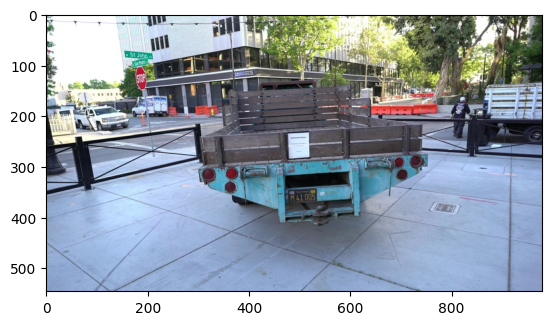

In [20]:
# place image dataset in the ../dataset directory
img_gt = plt.imread(f"./dataset/truck/images/{cameras[i]['img_name']}.jpg")
plt.imshow(img_gt)
plt.show()

### Extracting 3D gaussian for each user_point 

In [21]:
from projection.projections import get_3D_indices

In [22]:
user_points = torch.tensor(([380,700, 550], [250, 260, 230]))
# scale point selection if input size mismatches cameras.json size

scale = 1
if WIDTH != img_gt.shape[1]:
    scale = WIDTH / img_gt.shape[1]
    user_points = torch.round(user_points * scale)

In [28]:
# Hyperparameter 
eps = 10

pcd_indices = get_3D_indices(filt_points, filt_depths, 
                             filt_indices, user_points, eps, opacities)

print(pcd_indices)

gaussian_mappings = pcd_array[pcd_indices, :] 

print(gaussian_mappings) 

Point 1: 
	 Depth: 2.3526742028762913
	 (x,y) => tensor([756, 505], dtype=torch.int32)
Point 2: 
	 Depth: 2.465981473265354
	 (x,y) => tensor([1403,  517], dtype=torch.int32)
Point 3: 
	 Depth: 2.391784046164558
	 (x,y) => tensor([1096,  462], dtype=torch.int32)
tensor([383486, 693020, 926538])
tensor([[2.8123, 0.4185, 0.0323],
        [2.7469, 0.2980, 1.3799],
        [2.7844, 0.2547, 0.7111]], dtype=torch.float64)


In [29]:
from sam.sam import SAM

sam = SAM("./sam/sam_vit_h_4b8939.pth")


Loading pth...DONE


In [30]:
def get_camera(i):
    # Get Extrinsic & intrinsic Matrices for first camera 
    extrinsic = get_extrinsic_matrix(cameras[i])  
    intrinsic = get_intrinsic_matrix(cameras[i]) 

    image = plt.imread(f"./dataset/truck/images/{cameras[i]['img_name']}.jpg")

    return extrinsic, intrinsic, image

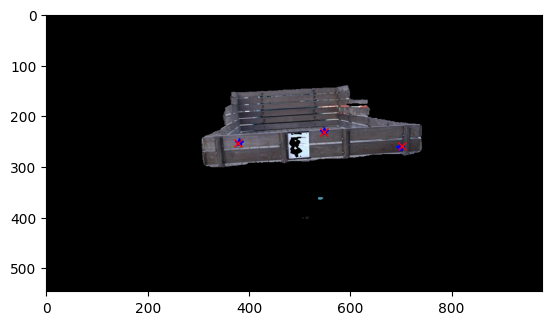

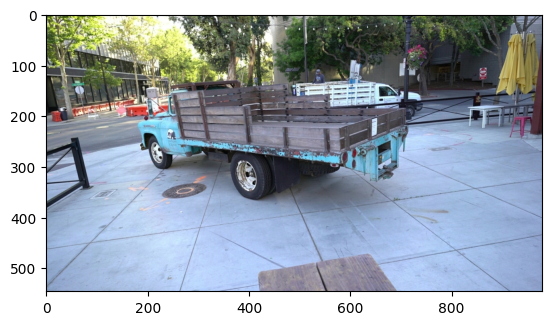

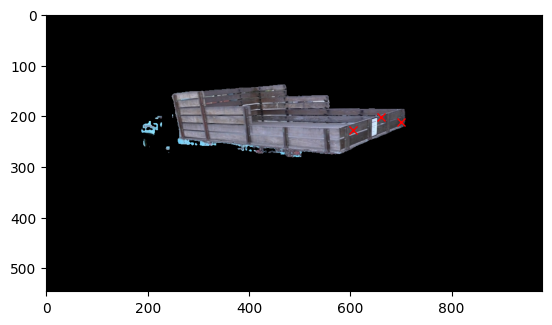

In [31]:
# get new view camera matrices
m_ex, m_in, img_view = get_camera(16)
prompt_cam = world_to_camera(gaussian_mappings, m_ex) 
prompt_2d, prompt_depths, prompt_indices_ = camera_to_image(prompt_cam, m_in)

input_points = prompt_2d.numpy().T
input_labels = np.array([1] * input_points.shape[0])

# scale point selection if input size mismatches cameras.json size
if WIDTH != img_gt.shape[1]:
    input_points = np.round(input_points / scale)



# draw reference pic (original input view)
ref_coords, ref_depths, ref_indices = camera_to_image(camera_coords[:,pcd_indices], intrinsic) 
if WIDTH != img_gt.shape[1]:
    ref_coords = np.round(ref_coords / scale)
mask_original, _, _ = sam.predict(img_gt, input_points,input_labels, multimask=False)
plt.imshow(mask_original[0][:,:,np.newaxis] * img_gt)
# red x marks 3d-to-2d projections, blue * marks original 2d input
plt.plot(user_points[0] // scale, user_points[1] // scale, 'b*')
plt.plot(ref_coords[0], ref_coords[1], 'rx')
plt.show()


plt.imshow(img_view)
plt.show()

# draw new view mask
mask_view, _, _ = sam.predict(img_view, input_points, input_labels, multimask=False)
plt.imshow(mask_view[0][:,:,np.newaxis] * img_view)
plt.plot(input_points[:,0], input_points[:,1], 'rx')
plt.show()